In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU, Reshape, Input,RepeatVector
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib
import sys
!{sys.executable} -m pip install hdf5storage
import hdf5storage
from os import path
from tensorflow.keras import layers, initializers
from sklearn.preprocessing import StandardScaler, MinMaxScaler

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 994.9 kB/s eta 0:00:00


# Data Process

In [ ]:
LOB_input = hdf5storage.loadmat('S092215-v50-AMZN_OCT2_states.mat')
df = pd.DataFrame.from_dict(LOB_input['LOB'])
df.columns = [
                      "Time", "Mid_Price", "Spread",
                      "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1", # Level 1
                      "AskPrice2", "AskVolume2","BidPrice2", "BidVolume2", # Level 2
                      "AskPrice3", "AskVolume3","BidPrice3", "BidVolume3", # Level 3
                      "AskPrice4", "AskVolume4","BidPrice4", "BidVolume4", # Level 4
                      "AskPrice5", "AskVolume5","BidPrice5", "BidVolume5", # Level 5
                      "AskPrice6", "AskVolume6","BidPrice6", "BidVolume6", # Level 6
                      "AskPrice7", "AskVolume7","BidPrice7", "BidVolume7", # Level 7
                      "AskPrice8", "AskVolume8","BidPrice8", "BidVolume8", # Level 8
                      "AskPrice9", "AskVolume9","BidPrice9", "BidVolume9", # Level 9
                      "AskPrice10", "AskVolume10","BidPrice10", "BidVolume10" # Level 10
                     ]

In [ ]:
lob_data=df.iloc[10:100010, [0, 1, 3, 4, 5, 6]]
lob_data['Time_int'] = df['Time'].diff()
lob_data=lob_data.iloc[:, 1:]
lob_data = lob_data[[lob_data.columns[-1]] + list(lob_data.columns[:-1])]
df=lob_data.copy()


In [ ]:
df

,Time_int,Mid_Price,AskPrice1,AskVolume1,BidPrice1,BidVolume1
10,0.0,5455800,5484000,100,5427600,100
11,0.0,5452000,5476400,100,5427600,100
12,0.0,5452000,5476400,100,5427600,100
13,72.0,5452050,5476400,100,5427700,100
14,0.0,5452000,5476300,100,5427700,100
...,...,...,...,...,...,...
100005,88.0,5413950,5421200,150,5406700,500
100006,0.0,5413950,5421200,150,5406700,500
100007,910.0,5413950,5421200,150,5406700,500
100008,0.0,5413950,5421200,150,5406700,500


In [ ]:
# scaler = MinMaxScaler()
# df = scaler.fit_transform(df).astype(np.float32)

In [ ]:
cols_price =['AskPrice1', 'BidPrice1','Mid_Price']
# Define the normalization range (0 to 2)
min_value = 0
max_value = 1

# Calculate the scaling factors
min_val = 0
max_val = 5507700

scaling_factor = (max_value - min_value) / (max_val - min_val)

def feature_scale(column):
    scaled = min_value + (column - min_value) * scaling_factor
    return scaled

# Apply feature scaling to the selected columns
df[cols_price] = df[cols_price].apply(feature_scale)

#-----------------------------------------------------------
cols_vol =['AskVolume1', 'BidVolume1']
# Define the normalization range (0 to 2)
min_value1 = 0
max_value1 = 1

# Calculate the scaling factors
min_val1 = 0
max_val1 = 1250

scaling_factor1 = (max_value1 - min_value1) / (max_val1 - min_val1)

def feature_scale1(column):
    scaled = min_value1 + (column - min_value1) * scaling_factor1
    return scaled

# Apply feature scaling to the selected columns
df[cols_vol] = df[cols_vol].apply(feature_scale1)
#---------------------
cols_to_feature_scale = ['Time_int']

# Custom scaling range for the feature scaling
custom_min = 0
custom_max = 1

# Calculate the minimum and maximum values for each column
min_values = 0
max_values =  169619

# Feature scaling function
def feature_scale(column):
    scaled = custom_min + (column - min_values) * (custom_max - custom_min) / (max_values - min_values)
    return scaled

# Apply feature scaling to the selected columns
df[cols_to_feature_scale] = df[cols_to_feature_scale].apply(feature_scale)
lob=df.copy()

In [ ]:
df

,Time_int,Mid_Price,AskPrice1,AskVolume1,BidPrice1,BidVolume1
10,0.000000,0.990577,0.995697,0.08,0.985457,0.08
11,0.000000,0.989887,0.994317,0.08,0.985457,0.08
12,0.000000,0.989887,0.994317,0.08,0.985457,0.08
13,0.000424,0.989896,0.994317,0.08,0.985475,0.08
14,0.000000,0.989887,0.994299,0.08,0.985475,0.08
...,...,...,...,...,...,...
100005,0.000519,0.982978,0.984295,0.12,0.981662,0.40
100006,0.000000,0.982978,0.984295,0.12,0.981662,0.40
100007,0.005365,0.982978,0.984295,0.12,0.981662,0.40
100008,0.000000,0.982978,0.984295,0.12,0.981662,0.40


In [ ]:
df.describe()

,Time_int,Mid_Price,AskPrice1,AskVolume1,BidPrice1,BidVolume1
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.001161,0.954431,0.975204,0.063022,0.962163,0.058475
std,0.009394,0.165952,0.107595,0.033134,0.130242,0.052120
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.981880,0.983568,0.020000,0.981353,0.016000
50%,0.000006,0.984031,0.985784,0.080000,0.982279,0.080000
75%,0.000330,0.985212,0.989506,0.080000,0.982879,0.080000
max,1.000000,0.993391,1.000000,0.720000,0.987545,1.000000


In [ ]:
def create_sliding_window(data, window_size):
    sequences = []
    for i in range(len(data) - window_size):
        sequences.append(data[i:i+window_size])
    return np.array(sequences)

# Set the window size (determine how many time steps to consider for each input sequence)
lob=create_sliding_window(df, 1)

## Training Process

In [ ]:
# Define the generator
def make_rnn(n_layers, hidden_units, output_units, name):
    x = Input(shape=(None, hidden_units))
    h = x
    for _ in range(n_layers):
        h = GRU(units=hidden_units, return_sequences=True)(h)
    y = Dense(units=output_units, activation='tanh', name=name)(h)
    return Model(inputs=x, outputs=y, name=name)

def build_generator(latent_dim, window_size, num_features, gru_units):
    hidden_dim = 3
    # Input for noise
    input_noise = Input(shape=(latent_dim,))

    # Repeat the noise vector to match the length of the time series data
    repeated_noise = RepeatVector(window_size)(input_noise)

    # First GRU layer to learn sequential patterns
    gru_layer1 = GRU(units=gru_units, return_sequences=True)(repeated_noise)

    # Second GRU layer to learn further sequential patterns
    gru_layer2 = GRU(units=gru_units, return_sequences=True)(gru_layer1)

    # Output layer to generate synthetic time series data
    output_data = Dense(units=num_features, activation='sigmoid')(gru_layer2)

    # Reshape the output_data to match the input shape of the Embedder
    reshaped_output_data = Reshape((window_size, num_features))(output_data)

    # Define the Embedder and Recovery components
    embedder = make_rnn(n_layers=3, hidden_units=num_features, output_units=hidden_dim, name='Embedder')
    recovery = make_rnn(n_layers=3, hidden_units=hidden_dim, output_units=num_features, name='Recovery')

    # Connect the Embedder, generator, and Recovery
    embedded_data = embedder(reshaped_output_data)
    recovered_data = recovery(embedded_data)

    generator = Model(inputs=input_noise, outputs=recovered_data)
    return generator


# Define the discriminator
def build_discriminator(window_size, num_features, num_units):
    input_data = Input(shape=(window_size, num_features))

    x = GRU(units=num_units, return_sequences=True)(input_data)
    x = LeakyReLU(alpha=0.2)(x)
    x = Flatten()(x)
    x = Dense(units=1, activation='sigmoid')(x)

    discriminator = Model(inputs=input_data, outputs=x)
    return discriminator

def generator_loss(fake_output, fake_features, target_features, para):
    # Wasserstein GAN loss
    wgan_loss = -tf.reduce_mean(fake_output)

#     # Feature Matching Term (L2 distance between fake and real features)
    feature_matching_loss = tf.reduce_mean(tf.square(fake_features - target_features))
    feature_matching_loss = tf.convert_to_tensor(feature_matching_loss)
    # Total Generator Loss
    total_gen_loss = wgan_loss + para * feature_matching_loss

    return total_gen_loss

# Define the discriminator loss function
def discriminator_loss(real_output, fake_output):
    # Wasserstein GAN loss
    wgan_loss = tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)
    return wgan_loss

# Create a function to generate new data using the trained generator
def generate_new_data(generator, latent_dim, num_samples):
    noise = np.random.normal(0, 1, size=(num_samples, latent_dim))
    generated_data = generator.predict(noise)
    return generated_data

# Function to calculate gradient penalty
def gradient_penalty(discriminator, real_samples, generated_samples,labmda):
    # Randomly sample points between real and generated data
    alpha = tf.random.uniform(shape=[real_samples.shape[0], 1, 1], minval=0.0, maxval=1.0)
    interpolates = alpha * real_samples + (1 - alpha) * generated_samples

    with tf.GradientTape() as gp_tape:
        gp_tape.watch(interpolates)
        disc_interpolates = discriminator(interpolates)

    # Calculate gradients of the discriminator with respect to the interpolated points
    gradients = gp_tape.gradient(disc_interpolates, interpolates)
    gradients_norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
    gradient_penalty = labmda*tf.reduce_mean((gradients_norm - 1) ** 2)

    return gradient_penalty

# Example usage
if __name__ == "__main__":
    # Set hyperparameters
    latent_dim = 100
    window_size = 1
    num_features = 6
    gru_units = 64
    num_filters = 128
    para = 0.0055
    labmda = 5

    # Build the generator and discriminator
    generator = build_generator(latent_dim, window_size, num_features, gru_units)
    discriminator = build_discriminator(window_size, num_features, num_filters)

    # Compile the models
    generator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5),
                      loss=generator_loss)
    discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5),
                          loss=discriminator_loss)

    # Combine the generator and discriminator to create the GAN
    z = Input(shape=(latent_dim,))
    generated_data = generator(z)
    validity = discriminator(generated_data)

    gan = Model(z, validity)
    gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5),
                loss=generator_loss)

    # Load and preprocess your original dataset (lob_10)
    # Replace the following line with your own data loading and preprocessing code
    original_data = np.random.random(size=(1000, window_size, num_features))


epochs = 5000
batch_size = 128
clip_value = 0.01
n_critic = 5  # Number of times to train the critic per generator iteration

# Load and preprocess your original dataset (lob_10)

# Define optimizers for generator and discriminator
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005, beta_1=0.5)


#-------------------------------------------------------------------------------------------

disc_losses = []
gen_losses = []
# Training loop
for epoch in range(epochs):
    for _ in range(n_critic):
        # ---------------------
        #  Train Discriminator
        # ---------------------

        # Select a random batch of real data
        idx = np.random.randint(0, original_data.shape[0], batch_size)
        real_samples = original_data[idx]

        # Generate a batch of noise samples
        noise = np.random.normal(0, 1, size=(batch_size, latent_dim))

        with tf.GradientTape() as disc_tape:
            # Generate a batch of fake data
            generated_data = generator(noise)

            # Compute discriminator outputs for real and fake data
            real_output = discriminator(real_samples)
            fake_output = discriminator(generated_data)

            # Compute Wasserstein GAN loss for the discriminator
            disc_loss = discriminator_loss(real_output, fake_output)

            # Compute gradient penalty
            gp = gradient_penalty(discriminator, real_samples, generated_data,labmda)

            # Add gradient penalty to the discriminator loss
            disc_loss += gp

        # Get gradients of the discriminator loss with respect to the discriminator's parameters
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        # Apply gradient clipping to prevent gradient explosion
        clipped_gradients = [tf.clip_by_value(grad, -clip_value, clip_value) for grad in gradients_of_discriminator]

        # Update the discriminator's parameters using the optimizer
        discriminator_optimizer.apply_gradients(zip(clipped_gradients, discriminator.trainable_variables))

    # ---------------------
    #  Train Generator
    # ---------------------

    # Generate a batch of noise samples
    noise = np.random.normal(0, 1, size=(batch_size, latent_dim))



    intermediate_layer_model = Model(inputs=discriminator.input,
                                 outputs=discriminator.layers[-2].output)
    def get_discriminator_features(data):
        return intermediate_layer_model(data)








    with tf.GradientTape() as gen_tape:
        # Generate a batch of fake data
        generated_data = generator(noise)

        # Compute discriminator outputs for the generated data
        fake_output = discriminator(generated_data)

        # Compute feature matching loss
        target_features = get_discriminator_features(real_samples)
        fake_features=get_discriminator_features(generated_data).numpy()


        gen_loss = generator_loss(fake_output, fake_features, target_features, para)

#     # Get gradients of the generator loss with respect to the generator's parameters
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    #record the loss
    disc_losses.append(disc_loss.numpy())
    gen_losses.append(gen_loss.numpy())


    # Update the generator's parameters using the optimizer
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))



    # Print the progress
    print(f"Epoch {epoch}/{epochs} [D loss: {disc_loss}] [G loss: {gen_loss}]")

    # Optionally, save generated data during training
    if epoch % 100 == 0:
        generated_data = generate_new_data(generator, latent_dim, num_samples=100)
        # Save or visualize generated_data here

流式输出内容被截断，只能显示最后 5000 行内容。
Epoch 49/5000 [D loss: 0.10714653134346008] [G loss: -0.40471604466438293]
Epoch 50/5000 [D loss: 0.1386111080646515] [G loss: -0.4058675169944763]
Epoch 51/5000 [D loss: 0.10401126742362976] [G loss: -0.4041638672351837]
Epoch 52/5000 [D loss: 0.07241290807723999] [G loss: -0.40413081645965576]
Epoch 53/5000 [D loss: 0.018637895584106445] [G loss: -0.4016694724559784]
Epoch 54/5000 [D loss: -0.004661351442337036] [G loss: -0.40267154574394226]
Epoch 55/5000 [D loss: -0.021361321210861206] [G loss: -0.40079960227012634]
Epoch 56/5000 [D loss: -0.05187350511550903] [G loss: -0.3968351483345032]
Epoch 57/5000 [D loss: -0.1203559935092926] [G loss: -0.39534053206443787]
Epoch 58/5000 [D loss: -0.11033084988594055] [G loss: -0.39028286933898926]
Epoch 59/5000 [D loss: -0.013252735137939453] [G loss: -0.38823628425598145]
Epoch 60/5000 [D loss: -0.030671805143356323] [G loss: -0.38415876030921936]
Epoch 61/5000 [D loss: -0.07082241773605347] [G loss: -0.3796779513

# Generate data

In [ ]:
# Sample random noise
num_samples_to_generate = 99999
noise = tf.random.normal([num_samples_to_generate, latent_dim])

# Generate samples
generated_samples = generator(noise, training=False)

In [ ]:
generated_samples.shape

TensorShape([99999, 1, 6])

In [ ]:
# Drop dimension-1 (size 10) from the tensor using tf.reshape
fake = tf.reshape(generated_samples, shape=(-1, num_features))
real = tf.reshape(df, shape=(-1, num_features))
print(fake.shape)

(99999, 6)


# Visualization

In [ ]:
fake_sel = fake[fake[:, 2] > fake[:, 4]]
real_sel= real[real[:, 2] > real[:, 4]]

In [ ]:
real_sel=real_sel[:56223]

## Real Mid-price


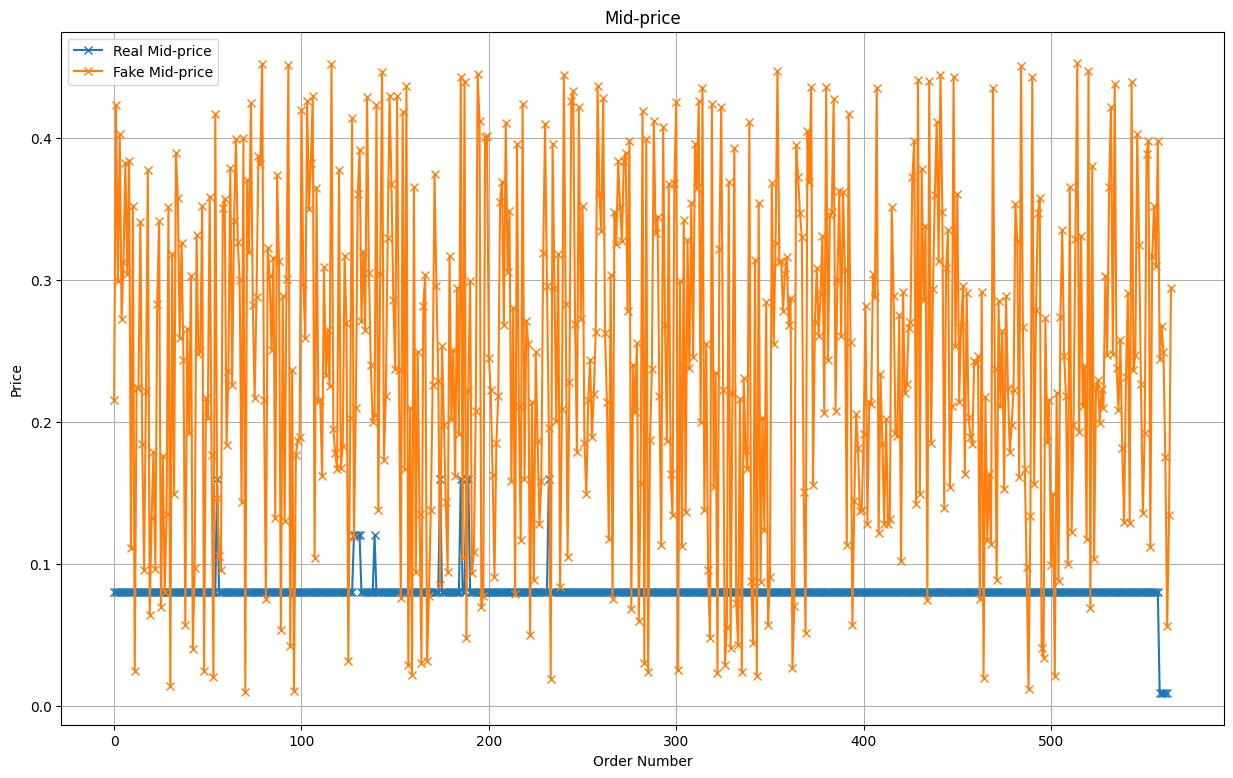

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(real_sel[::100,3], marker='x', linestyle='-' ,label='Real Mid-price')
plt.plot(fake_sel[::100,3], marker='x', linestyle='-', label='Fake Mid-price')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Price')
plt.title('Mid-price')

# Add a legend to distinguish the lines
plt.legend()

# # Adjust the aspect ratio (width / height) as desired
# plt.gca().set_aspect(1.5)  # Increase the number to make x-axis wider, decrease to make y-axis taller

# Display the plot
plt.grid(True)

plt.show()

## Pairplot

<ipython-input-81-34eafbea4c62>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  real_df['Type'] = 'Real'
<ipython-input-81-34eafbea4c62>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fake_df['Type'] = 'Generated'


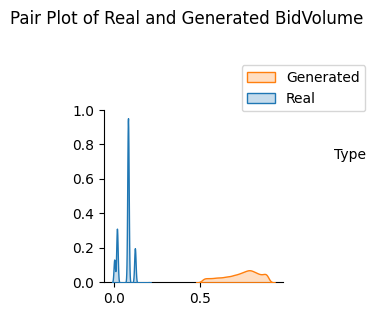

In [ ]:
import pandas as pd
import seaborn as sns

# Assuming real_sel and fake_sel are NumPy arrays or pandas DataFrames with multiple columns
# Example DataFrames
real_sel_df = pd.DataFrame(real_sel, columns=["Time_int", "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])
fake_sel_df = pd.DataFrame(fake_sel, columns=['Time_int', "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])

# Create a combined DataFrame with an additional 'Source' column to differentiate real and fake data
name='BidVolume1'
# Create DataFrames with only the 'Time' column
real_df = real_sel_df[[name]]
fake_df = fake_sel_df[[name]]

# Create a combined DataFrame with an additional 'Source' column to differentiate real and fake data
real_df['Type'] = 'Real'
fake_df['Type'] = 'Generated'
combined_time_df = pd.concat([real_df, fake_df])

# Create the pair plot for the 'Time' column only
# Create the pair plot for the 'Time' column only
pair_plot = sns.pairplot(combined_time_df, hue='Type', markers='x', diag_kws={'legend': False})
pair_plot.fig.suptitle('Pair Plot of Real and Generated BidVolume ', y=1.3)
plt.subplots_adjust(top=0.9)
# Create a new legend with custom labels

labels = [ 'Generated','Real']
plt.legend( labels,bbox_to_anchor=(1.5, 1.3), loc='upper right')

# Remove x-axis and y-axis labels
for ax in pair_plot.axes.flatten():
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.savefig('BidVolume1.png', bbox_inches='tight', dpi=300)

# pair_plot = sns.pairplot(combined_df, hue='Type', markers='x', diag_kws={'legend': False},
#                          corner=True, corner_labels=features)

plt.show()


## Real Bids And Ask

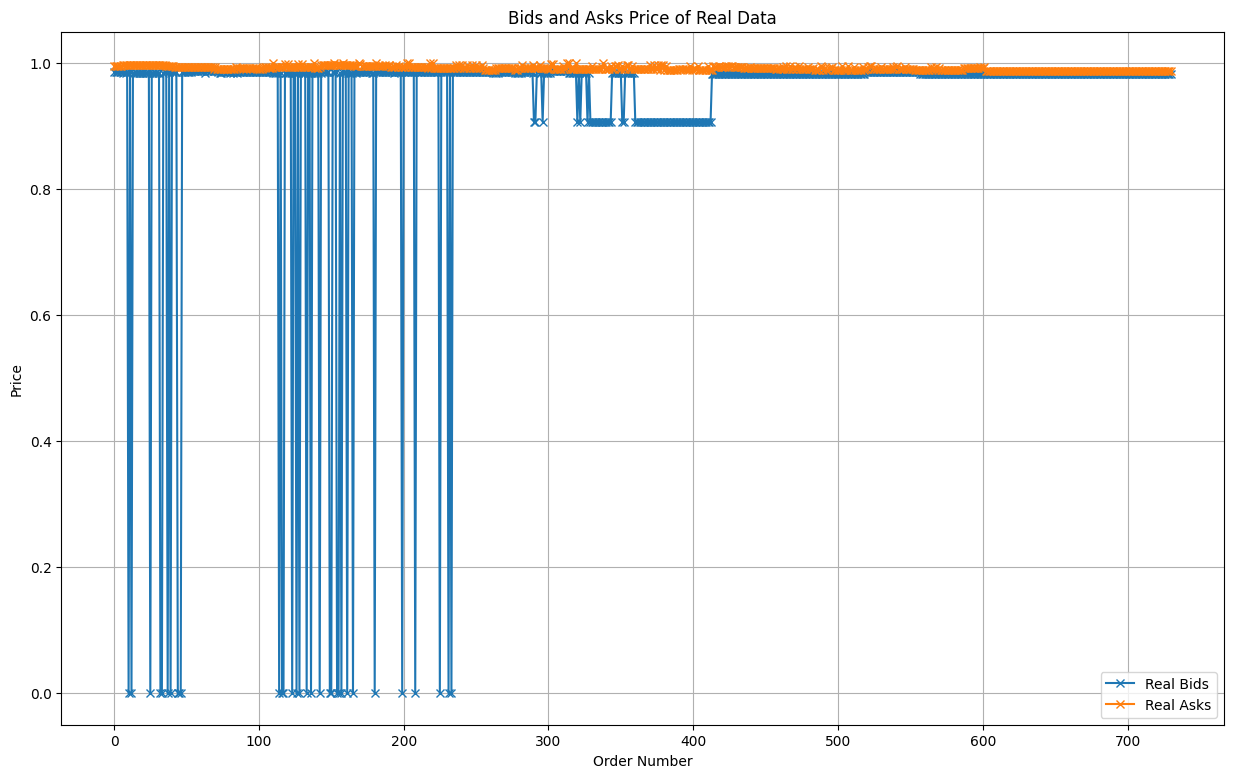

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(real_sel[::50,4], marker='x', linestyle='-' ,label='Real Bids')
plt.plot(real_sel[::50,2], marker='x', linestyle='-', label='Real Asks')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Price')
plt.title('Bids and Asks Price of Real Data')

# Add a legend to distinguish the lines
plt.legend()

# # Adjust the aspect ratio (width / height) as desired
# plt.gca().set_aspect(1.5)  # Increase the number to make x-axis wider, decrease to make y-axis taller

# Display the plot
plt.grid(True)
plt.savefig('realprice.png', bbox_inches='tight', dpi=300)
plt.show()

## Generated Bids And Ask

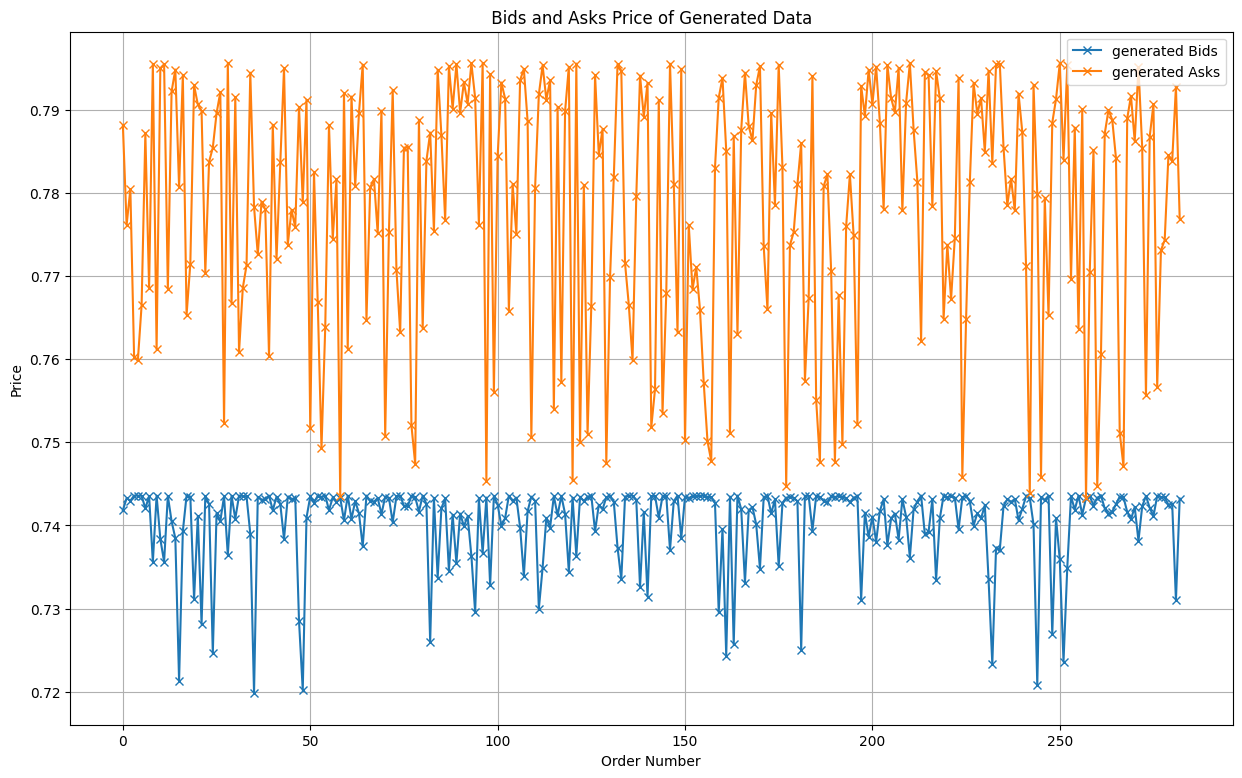

In [ ]:
plt.figure(figsize=(15, 9))


# Create the plot
plt.plot(fake_sel[::200,4], marker='x', linestyle='-' ,label='generated Bids')
plt.plot(fake_sel[::200,2], marker='x', linestyle='-', label='generated Asks')
# plt.plot(plot_f.iloc[:,4], marker='x', linestyle='--', label='Fake Bids')
# plt.plot(plot_f.iloc[:,2], plot_f.iloc[:,1], marker='x', linestyle='--', label='Fake Asks')

# Add labels and title
plt.xlabel('Order Number')
plt.ylabel('Price')
plt.title(' Bids and Asks Price of Generated Data ')

# Add a legend to distinguish the lines
plt.legend(loc='upper right')



# Display the plot
plt.grid(True)
plt.savefig('fakeprice.png', bbox_inches='tight', dpi=300)
plt.show()

## PCA and tSNE

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

sample_size = 250
seq_len = 5
idx = np.random.permutation(len(real_sel))[:sample_size]

real_sample = np.asarray(real_sel)[idx]
synthetic_sample = np.asarray(fake_sel)[idx]

#for the purpose of comparision we need the data to be 2-Dimensional. For that reason we are going to use only two componentes for both the PCA and TSNE.
synth_data_reduced = real_sample.reshape(-1, seq_len)
stock_data_reduced = np.asarray(synthetic_sample).reshape(-1,seq_len)

n_components = 2
pca = PCA(n_components=n_components)
tsne = TSNE(n_components=n_components, n_iter=300)

#The fit of the methods must be done only using the real sequential data
pca.fit(stock_data_reduced)

pca_real = pd.DataFrame(pca.transform(stock_data_reduced))
pca_synth = pd.DataFrame(pca.transform(synth_data_reduced))

data_reduced = np.concatenate((stock_data_reduced, synth_data_reduced), axis=0)
tsne_results = pd.DataFrame(tsne.fit_transform(data_reduced))

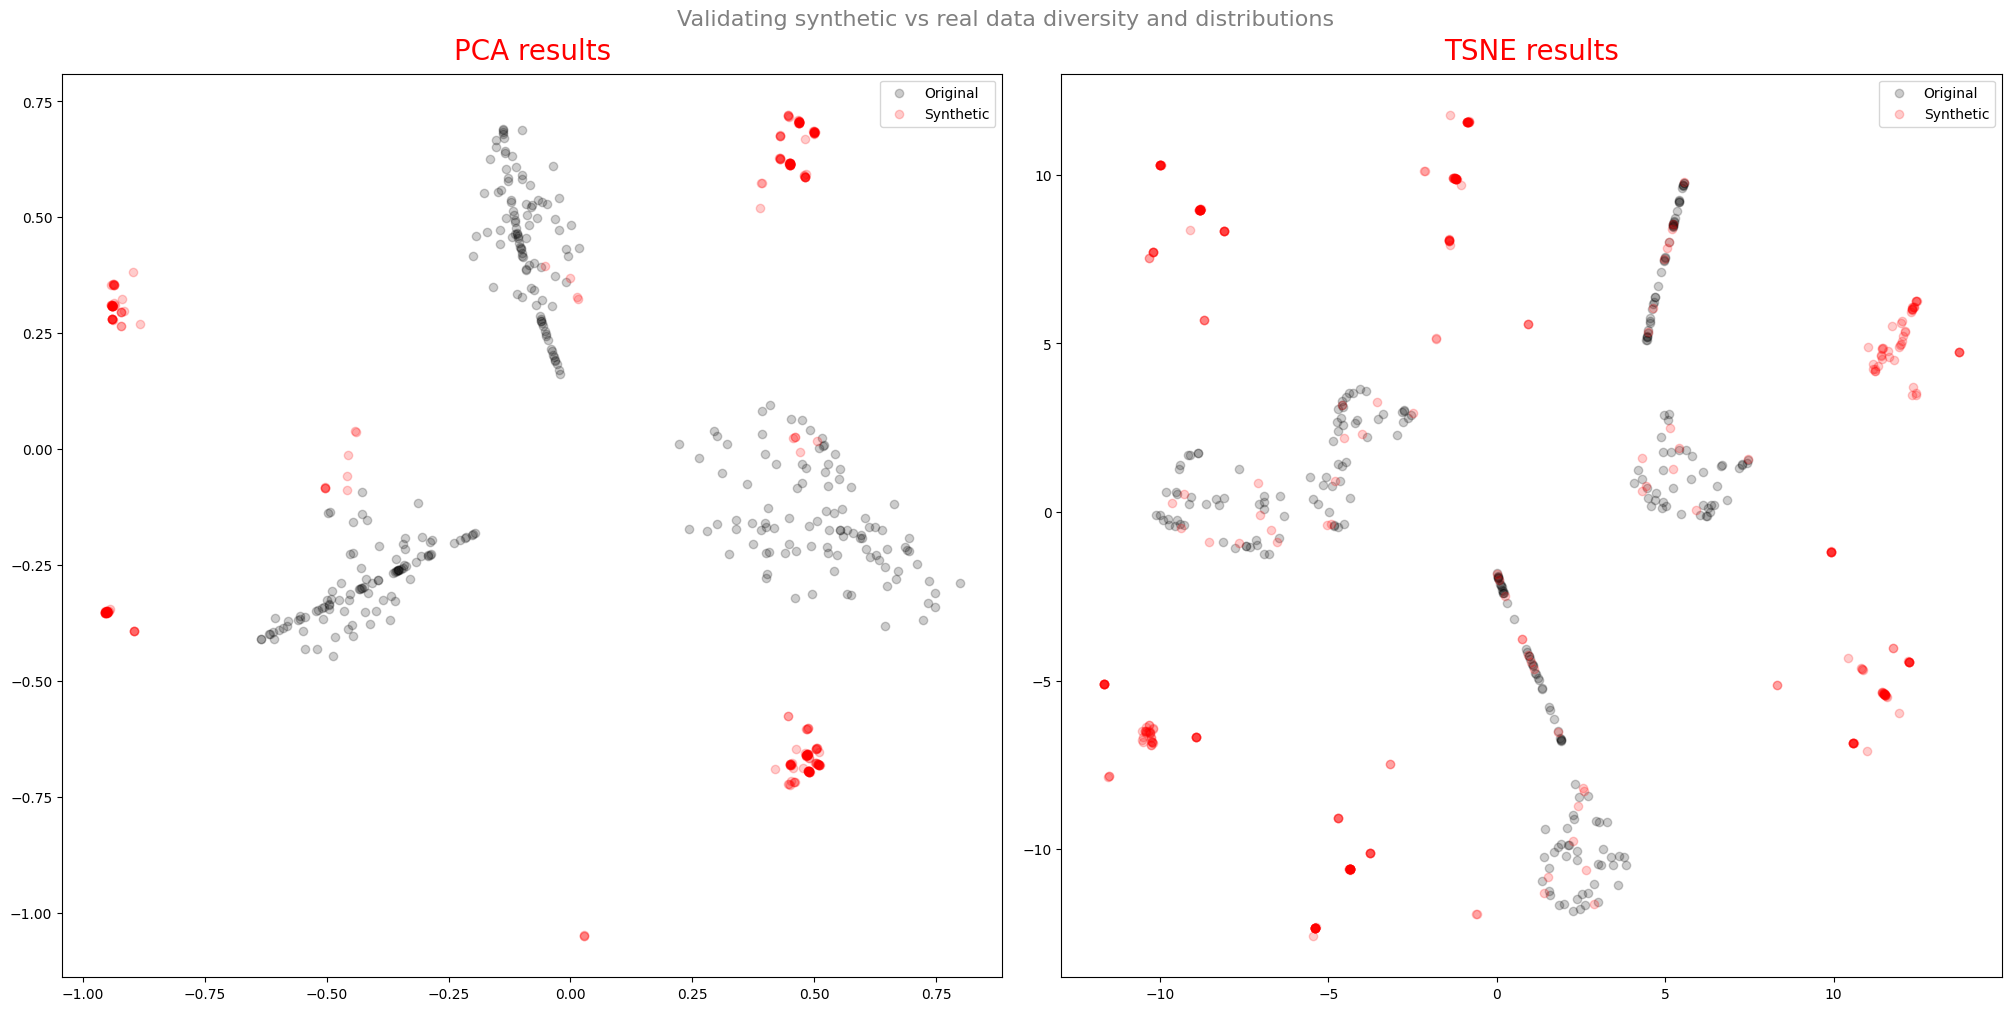

In [ ]:
import matplotlib.gridspec as gridspec
fig = plt.figure(constrained_layout=True, figsize=(20,10))
spec = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)

#TSNE scatter plot
ax = fig.add_subplot(spec[0,0])
ax.set_title('PCA results',
             fontsize=20,
             color='red',
             pad=10)

#PCA scatter plot
plt.scatter(pca_real.iloc[:, 0].values, pca_real.iloc[:,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(pca_synth.iloc[:,0], pca_synth.iloc[:,1],
            c='red', alpha=0.2, label='Synthetic')
ax.legend()

ax2 = fig.add_subplot(spec[0,1])
ax2.set_title('TSNE results',
              fontsize=20,
              color='red',
              pad=10)

plt.scatter(tsne_results.iloc[:sample_size, 0].values, tsne_results.iloc[:sample_size,1].values,
            c='black', alpha=0.2, label='Original')
plt.scatter(tsne_results.iloc[sample_size:,0], tsne_results.iloc[sample_size:,1],
            c='red', alpha=0.2, label='Synthetic')

ax2.legend()

fig.suptitle('Validating synthetic vs real data diversity and distributions',
             fontsize=16,
             color='grey')
plt.savefig('PCA.png', bbox_inches='tight', dpi=300)


# Prediction

In [ ]:
import sys
!{sys.executable} -m pip install hdf5storage
!{sys.executable} -m pip install tensorflow

# Import Libraries
import hdf5storage
import pandas as pd
import keras
from keras import layers
import numpy as np
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Conv2D,MaxPooling2D,LeakyReLU,LSTM,Dense,Reshape,Flatten
from keras.models import Model,Sequential
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error,precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def future_avg_label(df, mid_price_col, k, alpha):
    """
    Compare the future average of a mid-price column in a pandas DataFrame to the mid-price column itself,
    and assign a label of 1 or -1 depending on whether the future average is larger than 1 + alpha.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the mid-price column.
    mid_price_col (str): The name of the mid-price column.
    k (int): The size of the future window.
    alpha (float): The threshold parameter for the label.

    Returns:
    A pandas Series containing the labels (-1 or 1).
    """
    # Compute the future average of the mid-price column using a rolling window of size k
    future_avg = df[mid_price_col].rolling(k).mean().shift(-k)

    # Compute the labels based on the future average and the mid-price column
    labels = pd.Series([1 if p >= 1 + alpha else -1 if p <= 1 - alpha else 0 for p in (future_avg / df[mid_price_col])])


    return labels

## fake data

0.06684097255571564
0.7957775287693648
0.13738149867491953


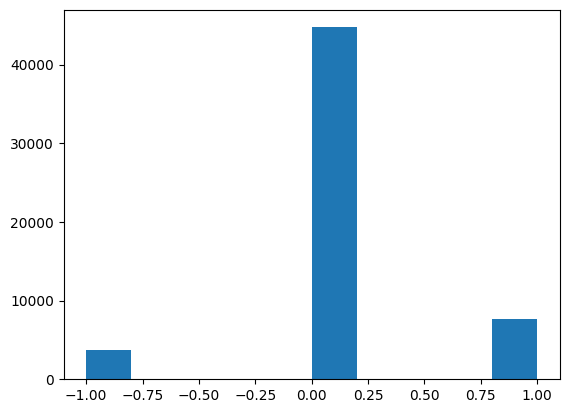

In [ ]:
def future_avg_label(df, mid_price_col, k, alpha):
    """
    Compare the future average of a mid-price column in a pandas DataFrame to the mid-price column itself,
    and assign a label of 1 or -1 depending on whether the future average is larger than 1 + alpha.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the mid-price column.
    mid_price_col (str): The name of the mid-price column.
    k (int): The size of the future window.
    alpha (float): The threshold parameter for the label.

    Returns:
    A pandas Series containing the labels (-1 or 1).
    """
    # Compute the future average of the mid-price column using a rolling window of size k
    future_avg = df[mid_price_col].rolling(k).mean().shift(-k)

    # Compute the labels based on the future average and the mid-price column
    labels = pd.Series([1 if p >= 1 + alpha else -1 if p <= 1 - alpha else 0 for p in (future_avg / df[mid_price_col])])


    return labels
fake_sel_df = pd.DataFrame(fake_sel.numpy(), columns=["Time_int", "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])
labels=future_avg_label(fake_sel_df,'Mid_Price', 5, 0.126)
z_score_f = fake_sel_df.assign(Label=labels)
plt.hist(z_score_f['Label'])

    # Identify the Columns that will be utilized as Inputs to the Regressors
Feature_Matrix_f =z_score_f.iloc[10:,2:-1]
# Mid_Price_Series = LOB_Amazon['Labels']
Forecasting_Variable_f = z_score_f.iloc[10:,-1]
print(len(labels[labels<0])/len(labels))
print(len(labels[labels==0])/len(labels))
print(len(labels[labels>0])/len(labels))

The following code are based on the code from Adam Ntakaris:

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Conv2D,MaxPooling2D,LeakyReLU,LSTM,Dense,Reshape,Flatten
from keras.models import Model,Sequential
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error,precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,r2_score

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')
counter = 0
for train_index,test_index in tscv.split(Feature_Matrix_f):
# for train_index, test_index in tscv.split(Feature_Matrix):

    counter += 1
    print('Fold %d:' %counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = Feature_Matrix_f.iloc[train_index,:], Feature_Matrix_f.iloc[test_index,:]
    Y_train, Y_test = Forecasting_Variable_f.iloc[train_index], Forecasting_Variable_f.iloc[test_index]
    print(62*'-')







    # Prepare CNN data - 3D Inputs of the format [samples, lookback period, features]
    #----------------------------------------------------------------------
    # Train Set
    #----------------------------------------------------------------------
    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

    look_back = 10
    x_train_append_matrix = []
    y_train_append_matrix = []

    for i in range(len(X_train)-look_back):
        feat_current_train = X_train_to_Numpy[i:i+look_back, :]
        label_current_train = Y_train_to_Numpy[i+look_back]
        x_train_append_matrix.append(feat_current_train)
        y_train_append_matrix.append(label_current_train)

    X_train_numpy = np.array(x_train_append_matrix)
    Y_train_numpy = np.array(y_train_append_matrix)

    #----------------------------------------------------------------------
    # Test Set
    #----------------------------------------------------------------------
    Y_test = Y_test.values.reshape(-1,1)

    X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
    Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()


    look_back = 10
    x_test_append_matrix = []
    y_test_append_matrix = []

    for i in range(len(X_test)-look_back):
        feat_current_test = X_test_to_Numpy[i:i+look_back, :]
        label_current_test = Y_test_to_Numpy[i+look_back]
        x_test_append_matrix.append(feat_current_test)
        y_test_append_matrix.append(label_current_test)

    X_test_numpy = np.array(x_test_append_matrix)
    Y_test_numpy = np.array(y_test_append_matrix)
     #----about y--------------
#     Y_train_numpy = keras.utils.to_categorical(Y_train_numpy, 3)
#     Y_test_numpy = keras.utils.to_categorical(Y_test_numpy, 3)


    #--------------------------------------------------------------------
   #                           CNN Model 
   #--------------------------------------------------------------
    print('**********************  CNN  ****************************')
    model_CNN = Sequential()
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back,X_train_numpy.shape[2])))
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(100, activation='relu'))

    model_CNN.add(Dense(1, activation='linear'))
    model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history=model_CNN.fit(X_train_numpy, Y_train_numpy, epochs=1, batch_size=128, verbose=2)


    #--------------------------------------------------------------------
    #                           Result report
    #--------------------------------------------------------------------


    # Yt= np.argmax(model.predict(X_test_numpy),axis=1)
    Yt_CNN = np.argmax(model_CNN.predict(X_test_numpy),axis=1)



    r_squared = r2_score(Y_test_numpy,  Yt_CNN)
    mae = mean_absolute_error(Y_test_numpy,  Yt_CNN)
    mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
    precision_CNN = precision_score(Y_test_numpy, Yt_CNN,average='weighted')
    recall_CNN = recall_score(Y_test_numpy, Yt_CNN,average='weighted')
    F1_CNN=2*(precision_CNN*recall_CNN)/(precision_CNN+recall_CNN)
    testScore_CNN = mean_squared_error(Y_test_numpy, Yt_CNN)




# Print the results
    # Print the progress
    print(f"Epoch {epoch}/{epochs} [r_squared: {r_squared}] [MAE: {mae}]")

    print('testScore_CNN:', testScore_CNN)
    print('precision_CNN:', precision_CNN)
    print('recall_CNN:', recall_CNN)
    print('F1_CNN:', F1_CNN)


    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 9373 TEST: 9368
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


74/74 - 1s - loss: 7.9829e-09 - accuracy: 0.8027 - 1s/epoch - 20ms/step
293/293 [==============================] - 1s 2ms/step


<ipython-input-57-1f6bb8d6d91d>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.02460988585216306] [MAE: 0.20709553323359692]
testScore_CNN: 0.20709553323359692
precision_CNN: 0.628697493418114
recall_CNN: 0.792904466766403
F1_CNN: 0.7013173373950066
##############################################################
Fold 2:
TRAIN: 18741 TEST: 9368
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


147/147 - 2s - loss: 8.1972e-09 - accuracy: 0.7979 - 2s/epoch - 13ms/step
293/293 [==============================] - 1s 2ms/step


<ipython-input-57-1f6bb8d6d91d>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.02586621959998947] [MAE: 0.20634751015174183]
testScore_CNN: 0.20634751015174183
precision_CNN: 0.6298842746423396
recall_CNN: 0.7936524898482582
F1_CNN: 0.7023481730238921
##############################################################
Fold 3:
TRAIN: 28109 TEST: 9368
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


220/220 - 4s - loss: 8.3365e-09 - accuracy: 0.7964 - 4s/epoch - 17ms/step
293/293 [==============================] - 1s 2ms/step


<ipython-input-57-1f6bb8d6d91d>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.02524271780871956] [MAE: 0.2138277409702928]
testScore_CNN: 0.2138277409702928
precision_CNN: 0.618066820867873
recall_CNN: 0.7861722590297072
F1_CNN: 0.6920573508443382
##############################################################
Fold 4:
TRAIN: 37477 TEST: 9368
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


293/293 - 3s - loss: 8.4220e-09 - accuracy: 0.7938 - 3s/epoch - 12ms/step
293/293 [==============================] - 1s 2ms/step


<ipython-input-57-1f6bb8d6d91d>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.02605215990098153] [MAE: 0.2006839068176961]
testScore_CNN: 0.2006839068176961
precision_CNN: 0.6389062168202215
recall_CNN: 0.7993160931823039
F1_CNN: 0.7101656226396997
##############################################################
Fold 5:
TRAIN: 46845 TEST: 9368
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


366/366 - 4s - loss: 8.4377e-09 - accuracy: 0.7949 - 4s/epoch - 12ms/step
293/293 [==============================] - 1s 2ms/step


<ipython-input-57-1f6bb8d6d91d>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))


Epoch 4999/5000 [r_squared: -0.02453141872857545] [MAE: 0.20025646505663602]
testScore_CNN: 0.20025646505663602
precision_CNN: 0.6395897216837075
recall_CNN: 0.7997435349433639
F1_CNN: 0.7107565153207617
##############################################################


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## real data

0.1526997781004301
0.7965372709092403
0.05076295099032956


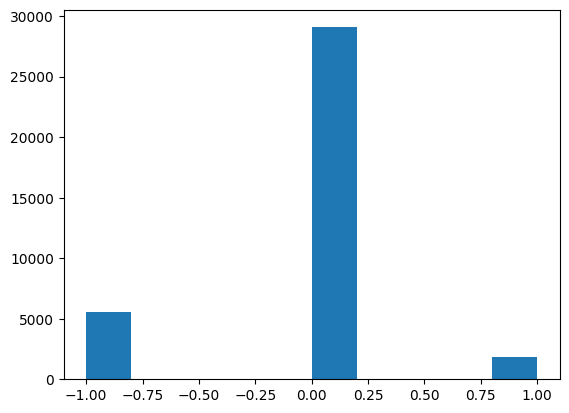

In [ ]:
def future_avg_label(df, mid_price_col, k, alpha):
    """
    Compare the future average of a mid-price column in a pandas DataFrame to the mid-price column itself,
    and assign a label of 1 or -1 depending on whether the future average is larger than 1 + alpha.

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the mid-price column.
    mid_price_col (str): The name of the mid-price column.
    k (int): The size of the future window.
    alpha (float): The threshold parameter for the label.

    Returns:
    A pandas Series containing the labels (-1 or 1).
    """
    # Compute the future average of the mid-price column using a rolling window of size k
    future_avg = df[mid_price_col].rolling(k).mean().shift(-k)

    # Compute the labels based on the future average and the mid-price column
    labels = pd.Series([1 if p >= 1 + alpha else -1 if p <= 1 - alpha else 0 for p in (future_avg / df[mid_price_col])])


    return labels
real_sel_df = pd.DataFrame(real_sel.numpy(), columns=["Time_int", "Mid_Price", "AskPrice1", "AskVolume1","BidPrice1", "BidVolume1"])
labels=future_avg_label(real_sel_df,'Mid_Price', 5, 0.0032)
z_score = real_sel_df.assign(Label=labels)
plt.hist(z_score['Label'])

    # Identify the Columns that will be utilized as Inputs to the Regressors
Feature_Matrix =z_score.iloc[10:,2:-1]
# Mid_Price_Series = LOB_Amazon['Labels']
Forecasting_Variable = z_score.iloc[10:,-1]
print(len(labels[labels<0])/len(labels))
print(len(labels[labels==0])/len(labels))
print(len(labels[labels>0])/len(labels))

In [ ]:
from keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D,Conv2D,MaxPooling2D,LeakyReLU,LSTM,Dense,Reshape,Flatten
from keras.models import Model,Sequential
from sklearn.metrics import classification_report, accuracy_score,mean_squared_error,precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error,r2_score

tscv = TimeSeriesSplit()
print(tscv)
print(62*'#')
counter = 0
for train_index,test_index in tscv.split(Feature_Matrix):
# for train_index, test_index in tscv.split(Feature_Matrix):

    counter += 1
    print('Fold %d:' %counter)
    print("TRAIN:", len(train_index), "TEST:", len(test_index))

    X_train, X_test = Feature_Matrix.iloc[train_index,:], Feature_Matrix.iloc[test_index,:]
    Y_train, Y_test = Forecasting_Variable.iloc[train_index], Forecasting_Variable.iloc[test_index]
    print(62*'-')







    # Prepare CNN data - 3D Inputs of the format [samples, lookback period, features]
    #----------------------------------------------------------------------
    # Train Set
    #----------------------------------------------------------------------
    X_train_to_Numpy = pd.DataFrame(X_train).to_numpy()
    Y_train_to_Numpy = pd.DataFrame(Y_train).to_numpy()

    look_back = 10
    x_train_append_matrix = []
    y_train_append_matrix = []

    for i in range(len(X_train)-look_back):
        feat_current_train = X_train_to_Numpy[i:i+look_back, :]
        label_current_train = Y_train_to_Numpy[i+look_back]
        x_train_append_matrix.append(feat_current_train)
        y_train_append_matrix.append(label_current_train)

    X_train_numpy = np.array(x_train_append_matrix)
    Y_train_numpy = np.array(y_train_append_matrix)

    #----------------------------------------------------------------------
    # Test Set
    #----------------------------------------------------------------------
    Y_test = Y_test.values.reshape(-1,1)

    X_test_to_Numpy = pd.DataFrame(X_test).to_numpy()
    Y_test_to_Numpy = pd.DataFrame(Y_test).to_numpy()


    look_back = 10
    x_test_append_matrix = []
    y_test_append_matrix = []

    for i in range(len(X_test)-look_back):
        feat_current_test = X_test_to_Numpy[i:i+look_back, :]
        label_current_test = Y_test_to_Numpy[i+look_back]
        x_test_append_matrix.append(feat_current_test)
        y_test_append_matrix.append(label_current_test)

    X_test_numpy = np.array(x_test_append_matrix)
    Y_test_numpy = np.array(y_test_append_matrix)
     #----about y--------------
#     Y_train_numpy = keras.utils.to_categorical(Y_train_numpy, 3)
#     Y_test_numpy = keras.utils.to_categorical(Y_test_numpy, 3)


    #--------------------------------------------------------------------
   #                           CNN Model
   #--------------------------------------------------------------
    print('**********************  CNN  ****************************')
    model_CNN = Sequential()
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(look_back,X_train_numpy.shape[2])))
    model_CNN.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model_CNN.add(MaxPooling1D(pool_size=2))
    model_CNN.add(Flatten())
    model_CNN.add(Dense(100, activation='relu'))

    model_CNN.add(Dense(1, activation='linear'))
    model_CNN.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

    history=model_CNN.fit(X_train_numpy, Y_train_numpy, epochs=1, batch_size=128, verbose=2)


    #--------------------------------------------------------------------
    #                           Result report
    #--------------------------------------------------------------------


    # Yt= np.argmax(model.predict(X_test_numpy),axis=1)
    Yt_CNN = np.argmax(model_CNN.predict(X_test_numpy),axis=1)



    r_squared = r2_score(Y_test_numpy,  Yt_CNN)
    mae = mean_absolute_error(Y_test_numpy,  Yt_CNN)
    mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
    precision_CNN = precision_score(Y_test_numpy, Yt_CNN,average='weighted')
    recall_CNN = recall_score(Y_test_numpy, Yt_CNN,average='weighted')
    F1_CNN=2*(precision_CNN*recall_CNN)/(precision_CNN+recall_CNN)
    testScore_CNN = mean_squared_error(Y_test_numpy, Yt_CNN)




# Print the results
    # Print the progress
    print(f"Epoch {epoch}/{epochs} [r_squared: {r_squared}] [MAE: {mae}][MRLE:{mrle}]")

    print('testScore_CNN:', testScore_CNN)
    print('precision_CNN:', precision_CNN)
    print('recall_CNN:', recall_CNN)
    print('F1_CNN:', F1_CNN)


    print(62*'#')

TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None)
##############################################################
Fold 1:
TRAIN: 6083 TEST: 6082
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


48/48 - 2s - loss: -2.3398e-08 - accuracy: 0.1740 - 2s/epoch - 48ms/step
190/190 [==============================] - 1s 6ms/step


<ipython-input-45-33501c41fd0e>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.13189442717253175] [MAE: 0.4733201581027668][MRLE:inf]
testScore_CNN: 0.4733201581027668
precision_CNN: 0.27739165586089454
recall_CNN: 0.5266798418972332
F1_CNN: 0.3633920462540133
##############################################################
Fold 2:
TRAIN: 12165 TEST: 6082
--------------------------------------------------------------


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


**********************  CNN  ****************************
95/95 - 3s - loss: -2.5735e-08 - accuracy: 0.5548 - 3s/epoch - 29ms/step
190/190 [==============================] - 1s 3ms/step


<ipython-input-45-33501c41fd0e>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.0949713844273159] [MAE: 0.3120882740447958][MRLE:inf]
testScore_CNN: 0.3120882740447958
precision_CNN: 0.47322254270666797
recall_CNN: 0.6879117259552042
F1_CNN: 0.5607195393335717
##############################################################
Fold 3:
TRAIN: 18247 TEST: 6082
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


143/143 - 3s - loss: -2.3682e-08 - accuracy: 0.5993 - 3s/epoch - 24ms/step
190/190 [==============================] - 1s 4ms/step


<ipython-input-45-33501c41fd0e>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.0095268401603954] [MAE: 0.015316205533596838][MRLE:inf]
testScore_CNN: 0.015316205533596838
precision_CNN: 0.9696021750847538
recall_CNN: 0.9846837944664032
F1_CNN: 0.9770847908247656
##############################################################
Fold 4:
TRAIN: 24329 TEST: 6082
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


190/190 - 5s - loss: -1.8122e-08 - accuracy: 0.6957 - 5s/epoch - 28ms/step
190/190 [==============================] - 1s 4ms/step


<ipython-input-45-33501c41fd0e>:105: RuntimeWarning: divide by zero encountered in log
  mrle = np.mean(np.abs(np.log(Y_test_numpy + 1) - np.log(Yt_CNN + 1)))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 4999/5000 [r_squared: -0.0033046926635820206] [MAE: 0.0032938076416337285][MRLE:inf]
testScore_CNN: 0.0032938076416337285
precision_CNN: 0.9934232338855126
recall_CNN: 0.9967061923583662
F1_CNN: 0.9950620053039974
##############################################################
Fold 5:
TRAIN: 30411 TEST: 6082
--------------------------------------------------------------
**********************  CNN  ****************************


/usr/local/lib/python3.10/dist-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


238/238 - 4s - loss: -1.4575e-08 - accuracy: 0.7559 - 4s/epoch - 19ms/step
190/190 [==============================] - 1s 5ms/step
Epoch 4999/5000 [r_squared: 1.0] [MAE: 0.0][MRLE:0.0]
testScore_CNN: 0.0
precision_CNN: 1.0
recall_CNN: 1.0
F1_CNN: 1.0
##############################################################
